In [5]:
# Acces the US Census Bureau API to obtain National Educational Attainment tables
# Compare the data with another access of the US Census Bureau API Unemployment rates 
import requests 
import pandas as pd
import numpy as np
API_KEY = "e74689afabd76081043a04b9d54c1b7e6e0304d8"
years = list(range(2013, 2018))


In [6]:
# Function to fetch data from a specified ACS table for a given year
def fetch_acs_data(year, table_id, fields, get_national=True):
    base_url = f"https://api.census.gov/data/{year}/acs/acs1/subject"
    get_vars = ",".join(fields)
    params = {
        "get": get_vars,
        "for": "us:1" if get_national else "state:*",
        "key": API_KEY
    }
    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print(f"Failed to fetch data for {year} - {table_id}")
        return None
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    df["year"] = year
    return df

# Educational attainment variables (e.g., % with Bachelor's degree or higher)
edu_vars = ["NAME", "S1501_C02_015E"]  # Percent Bachelor's degree or higher

# Unemployment rate variable from S2301 (e.g., unemployment rate for population 25 to 64)
unemp_vars = ["NAME", "S2301_C04_021E"]  # Unemployment rate: Age 25-64

edu_data = []
unemp_data = []

for year in years:
    edu = fetch_acs_data(year, "S1501", edu_vars)
    unemp = fetch_acs_data(year, "S2301", unemp_vars)
    
    if edu is not None and unemp is not None:
        edu_data.append(edu)
        unemp_data.append(unemp)

# Combine yearly data
edu_df = pd.concat(edu_data, ignore_index=True)
unemp_df = pd.concat(unemp_data, ignore_index=True)

# Merge the two datasets on year
merged_df = pd.merge(edu_df, unemp_df, on="year", suffixes=("_edu", "_unemp"))

# Convert relevant columns to numeric
merged_df["S1501_C02_015E"] = pd.to_numeric(merged_df["S1501_C02_015E"], errors='coerce')
merged_df["S2301_C04_021E"] = pd.to_numeric(merged_df["S2301_C04_021E"], errors='coerce')

# Display the merged data
print(merged_df[["year", "S1501_C02_015E", "S2301_C04_021E"]])

   year  S1501_C02_015E  S2301_C04_021E
0  2013            29.6             7.7
1  2014            29.9             6.6
2  2015            30.6             5.9
3  2016            31.3             5.3
4  2017            32.0             4.9


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Rename columns for clarity
merged_df = merged_df.rename(columns={
    "S1501_C02_015E": "bachelors_or_higher_pct",
    "S2301_C04_021E": "unemployment_rate"
})

# Drop any rows with missing values
merged_df = merged_df.dropna(subset=["bachelors_or_higher_pct", "unemployment_rate"])

# Define features and target
X = merged_df[["bachelors_or_higher_pct"]]  # Independent variable
y = merged_df["unemployment_rate"]          # Dependent variable

In [9]:
# Initialize and fit the model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

In [10]:
# Print regression metrics
print("Coefficient:", model.coef_[0])
print("Intercept:", model.intercept_)
print("R^2 score:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))

Coefficient: -1.070112589559877
Intercept: 38.911054247697024
R^2 score: 0.9081190847279637
Mean Squared Error: 0.09055783009211907


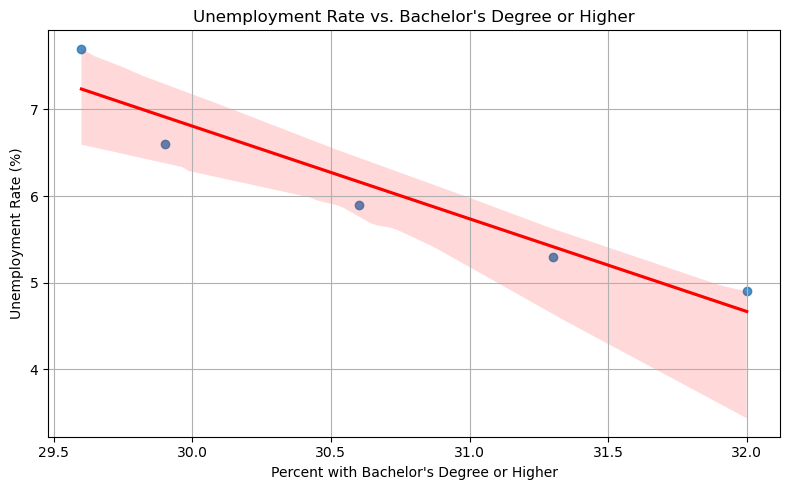

In [11]:
plt.figure(figsize=(8, 5))
sns.regplot(x="bachelors_or_higher_pct", y="unemployment_rate", data=merged_df, line_kws={"color": "red"})
plt.title("Unemployment Rate vs. Bachelor's Degree or Higher")
plt.xlabel("Percent with Bachelor's Degree or Higher")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()